In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir images
!tar xzf '/content/drive/My Drive/part1.tar.gz' -C images
!tar xzf '/content/drive/My Drive/part2.tar.gz' -C images
!tar xzf '/content/drive/My Drive/part3.tar.gz' -C images
!mv images/part1/* images
!mv images/part2/* images
!mv images/part3/* images

In [0]:
!rm -r images/part1
!rm -r images/part2
!rm -r images/part3

In [4]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 377.0MB 90kB/s 


In [0]:
import time
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, \
    ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [0]:
import os
def get_image_list(path='images', young_lower=18, young_upper=25, old_lower=50, old_upper=65):
    images = os.listdir(path)
    ages = {
        'young': [],
        'old': []
    }
    
    for image in images:
        age = int(image.split('_')[0])
        if young_lower <= age <= young_upper:
            ages['young'].append(image)
        if old_upper >= age >= old_lower:
            ages['old'].append(image)
        
    return ages

image_dataset = get_image_list()

In [0]:
from sklearn.utils import shuffle

def generator(gen_func, *args):
    while True:
        yield gen_func(*args)
        
def load_images(shuffle_data=True):
    X1 = []
    X2 = []
    x = 128
    images = get_image_list()['young']
    for img in images:
        image = cv2.imread(('images/' + img))[...,::-1]
        image = cv2.resize(image, (x, x))
        X1.append(image)
        
    images = get_image_list()['old']
    for img in images:
        image = cv2.imread(('images/' + img))[...,::-1]
        image = cv2.resize(image, (x, x))
        X2.append(image)
        
    X1 = np.array(X1) / 127.5 - 1.
    X2 = np.array(X2) / 127.5 - 1.
    
    return X1, X2


def load_test_batch(batch_size=2, shuffle_data=True):
    X1 = []
    X2 = []
    size = 128
    images = get_image_list()['young']
    to_create = images[:batch_size]
    for img in to_create:
        image = cv2.imread('images/' + img)[...,::-1]
        image = cv2.resize(image, (size, size))
        X1.append(image)
        
    images = get_image_list()['old']
    to_create = images[:batch_size]
    for img in to_create:
        image = cv2.imread('images/' + img)[...,::-1]
        image = cv2.resize(image, (size, size))
        X2.append(image)
        
    X1 = np.stack(X1).astype(np.float32)
    X2 = np.stack(X2).astype(np.float32)
    
    if shuffle_data:
        X1, X2 = shuffle(X1, X2)
        
    return (X1.astype(np.float32) / 127.5) - 1., (X2.astype(np.float32) / 127.5) - 1.

In [0]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, axis=1, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(0., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [0]:
def residual_block(x):
    """
    Residual block
    """
    res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
    res = Activation('relu')(res)

    res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(res)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)

    return Add()([res, x])


In [0]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    """
    input_shape = (128, 128, 3)
    residual_blocks = 6
    input_layer = Input(shape=input_shape)

    # First Convolution block
    x = Conv2D(filters=32, kernel_size=7, strides=1, padding="same")(input_layer)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 2nd Convolution block
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 3rd Convolution block
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # Residual blocks
    for _ in range(residual_blocks):
        x = residual_block(x)

    # Upsampling blocks

    # 1st Upsampling block
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 2nd Upsampling block
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # Last Convolution layer
    x = Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    output = Activation('tanh')(x)

    model = Model(inputs=[input_layer], outputs=[output])
    return model


def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    """
    input_shape = (128, 128, 3)
    hidden_layers = 3

    input_layer = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(1, 1))(input_layer)

    # 1st Convolutional block
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)

    # 3 Hidden Convolution blocks
    for i in range(1, hidden_layers + 1):
        x = Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
        x = InstanceNormalization(axis=1)(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = ZeroPadding2D(padding=(1, 1))(x)

    # Last Convolution layer
    output = Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)

    model = Model(inputs=[input_layer], outputs=[output])
    return model

In [0]:
def save_images(originalA, generatedB, recosntructedA, originalB, generatedA, reconstructedB, path):
    """
    Save images
    """
    image = plt.figure()
    ax = image.add_subplot(1,1,1)
    ax.imshow(originalA)
    ax.axis("off")
    ax.set_title("Original")
    plt.savefig(path + '_Original')

    image = plt.figure()
    ax = image.add_subplot(1,1,1)
    ax.imshow(generatedB)
    ax.axis("off")
    ax.set_title("Generated")
    plt.savefig(path)


In [0]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

W0818 17:49:20.516265 140337247364992 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0818 17:49:20.557439 140337247364992 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0818 17:49:20.596342 140337247364992 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0818 17:49:20.635595 140337247364992 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


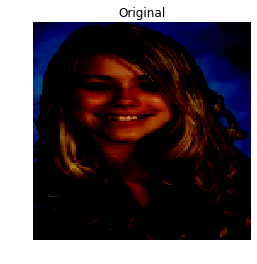

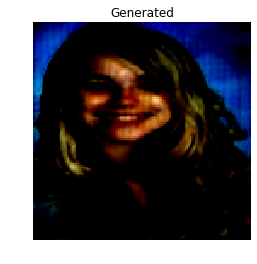

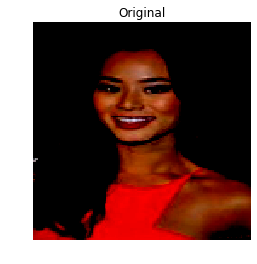

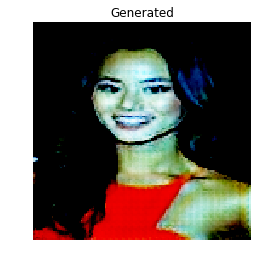

In [14]:
data_dir = "/content/images"
batch_size = 1
epochs = 120
mode = 'predict'

if mode == 'train':
    """
    Load dataset
    """
    imagesA, imagesB = load_images()

    # Define the common optimizer
    common_optimizer = Adam(0.0002, 0.5)

    # Build and compile generator networks
    discriminatorA = build_discriminator()
    discriminatorB = build_discriminator()

    discriminatorA.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])
    discriminatorB.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    discriminatorA.load_weights("/content/drive/My Drive/checkpoints/discriminatorA.h5")
    discriminatorB.load_weights("/content/drive/My Drive/checkpoints/discriminatorB.h5")

    # Build generator networks
    generatorAToB = build_generator()
    generatorBToA = build_generator()
    
    generatorAToB.load_weights("/content/drive/My Drive/checkpoints/generatorAToB.h5")
    generatorBToA.load_weights("/content/drive/My Drive/checkpoints/generatorBToA.h5")

    """
    Create an adversarial network
    """
    inputA = Input(shape=(128, 128, 3))
    inputB = Input(shape=(128, 128, 3))

    # Generated images using both of the generator networks
    generatedB = generatorAToB(inputA)
    generatedA = generatorBToA(inputB)

    # Reconstruct images back to original images
    reconstructedA = generatorBToA(generatedB)
    reconstructedB = generatorAToB(generatedA)

    generatedAId = generatorBToA(inputA)
    generatedBId = generatorAToB(inputB)

    # Make both of the discriminator networks non-trainable
    discriminatorA.trainable = False
    discriminatorB.trainable = False

    probsA = discriminatorA(generatedA)
    probsB = discriminatorB(generatedB)

    adversarial_model = Model(inputs=[inputA, inputB],
                              outputs=[probsA, probsB, reconstructedA, reconstructedB,
                                       generatedAId, generatedBId])
    adversarial_model.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                              loss_weights=[1, 1, 10.0, 10.0, 1.0, 1.0],
                              optimizer=common_optimizer)
    
    adversarial_model.load_weights("/content/drive/My Drive/checkpoints/adversarial.h5")


    real_labels = np.ones((batch_size, 7, 7, 1))
    fake_labels = np.zeros((batch_size, 7, 7, 1))

    for epoch in range(epochs):
        print("Epoch:{}".format(epoch))

        dis_losses = []
        gen_losses = []

        num_batches = int(min(imagesA.shape[0], imagesB.shape[0]) / batch_size)
        print("Number of batches:{}".format(num_batches))

        for index in range(num_batches):
            #print("Batch:{}".format(index))

            # Sample images
            batchA = imagesA[index * batch_size:(index + 1) * batch_size]
            batchB = imagesB[index * batch_size:(index + 1) * batch_size]

            # Translate images to opposite domain
            generatedB = generatorAToB.predict(batchA)
            generatedA = generatorBToA.predict(batchB)

            # Train the discriminator A on real and fake images
            dALoss1 = discriminatorA.train_on_batch(batchA, real_labels)
            dALoss2 = discriminatorA.train_on_batch(generatedA, fake_labels)

            # Train the discriminator B on ral and fake images
            dBLoss1 = discriminatorB.train_on_batch(batchB, real_labels)
            dbLoss2 = discriminatorB.train_on_batch(generatedB, fake_labels)

            # Calculate the total discriminator loss
            d_loss = 0.5 * np.add(0.5 * np.add(dALoss1, dALoss2), 0.5 * np.add(dBLoss1, dbLoss2))

            """
            Train the generator networks
            """
            g_loss = adversarial_model.train_on_batch([batchA, batchB],
                                                      [real_labels, real_labels, batchA, batchB, batchA, batchB])
            
            dis_losses.append(d_loss)
            gen_losses.append(g_loss)
            
            if index % 1000 == 0:
                print("d_loss:{}".format(d_loss))
                print("g_loss:{}".format(g_loss))

        # Sample and save images after every 10 epochs
        if epoch % 5 == 0:
            # Get a batch of test data
            batchA, batchB = load_test_batch(batch_size=2)

            # Generate images
            generatedB = generatorAToB.predict(batchA)
            generatedA = generatorBToA.predict(batchB)

            # Get reconstructed images
            reconsA = generatorBToA.predict(generatedB)
            reconsB = generatorAToB.predict(generatedA)

            # Save original, generated and reconstructed images
            for i in range(len(generatedA)):
                save_images(originalA=batchA[i], generatedB=generatedB[i], recosntructedA=reconsA[i],
                            originalB=batchB[i], generatedA=generatedA[i], reconstructedB=reconsB[i],
                            path="gen_{}_{}".format(epoch, i))
                
            generatorAToB.save_weights("/content/drive/My Drive/checkpoints/generatorAToB.h5")
            generatorBToA.save_weights("/content/drive/My Drive/checkpoints/generatorBToA.h5")
            discriminatorA.save_weights("/content/drive/My Drive/checkpoints/discriminatorA.h5")
            discriminatorB.save_weights("/content/drive/My Drive/checkpoints/discriminatorB.h5")
            adversarial_model.save_weights("/content/drive/My Drive/checkpoints/adversarial.h5")

    # Save models
    generatorAToB.save_weights("generatorAToB.h5")
    generatorBToA.save_weights("generatorBToA.h5")
    discriminatorA.save_weights("discriminatorA.h5")
    discriminatorB.save_weights("discriminatorB.h5")
    adversarial_model.save_weights("adversarial.h5")

elif mode == 'predict':
    # Build generator networks
    generatorAToB = build_generator()
    generatorBToA = build_generator()

    generatorAToB.load_weights("/content/drive/My Drive/checkpoints/generatorAToB.h5")
    generatorBToA.load_weights("/content/drive/My Drive/checkpoints/generatorBToA.h5")

    # Get a batch of test data
    batchA, batchB = load_test_batch(batch_size=2)

    # Save images
    generatedB = generatorAToB.predict(batchA)
    generatedA = generatorBToA.predict(batchB)

    reconsA = generatorBToA.predict(generatedB)
    reconsB = generatorAToB.predict(generatedA)
        
#     cv2_imshow(generatedB[1])
    
    for i in range(len(generatedA)):
        save_images(originalA=batchA[i], generatedB=generatedB[i], recosntructedA=reconsA[i],
                    originalB=batchB[i], generatedA=generatedA[i], reconstructedB=reconsB[i],
                    path="test_{}".format(i))